# Stock market chart pattern detection head and shoulder 

In [7]:
### 🧩 Head & Shoulders Full Workflow

In [8]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ ดึงข้อมูลจาก Cassandra

In [9]:
def get_candlestick_data(symbol: str, limit: int = 3000):
    """
    ดึงข้อมูลแท่งเทียนจาก Cassandra
    """
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
        query = """
            SELECT time, open_price, high_price, low_price, close_price, volume
            FROM candlestick_data
            WHERE symbol = %s
            ORDER BY time DESC
            LIMIT %s
        """
        rows = session.execute(query, (symbol, limit))
        df = pd.DataFrame(list(rows))

        if df.empty:
            print(f"⚠️ ไม่พบข้อมูลสำหรับ symbol '{symbol}'")
            return pd.DataFrame()

        df.rename(columns={
            'open_price': 'open',
            'high_price': 'high',
            'low_price': 'low',
            'close_price': 'close'
        }, inplace=True)

        df.sort_values('time', inplace=True)
        df.reset_index(drop=True, inplace=True)
        return df

    except Exception as e:
        raise ConnectionRefusedError(f"❌ ไม่สามารถเชื่อมต่อ Cassandra ได้: {e}")
    finally:
        try:
            cluster.shutdown()
        except:
            pass


# 2️⃣ ตรวจจับ Head & Shoulders

In [10]:
def detect_head_and_shoulders(df: pd.DataFrame):
    """
    ตรวจจับ Head and Shoulders แบบง่าย
    Returns: List of dict [{'Left_Shoulder':(idx,price), 'Head':..., 'Right_Shoulder':..., 'Neckline':...}]
    """
    df = df.copy()
    
    # หา local maxima / minima
    df['local_max'] = df['close'][(df['close'].shift(1) < df['close']) & (df['close'].shift(-1) < df['close'])]
    df['local_min'] = df['close'][(df['close'].shift(1) > df['close']) & (df['close'].shift(-1) > df['close'])]

    local_max_idx = df['local_max'].dropna().index
    local_min_idx = df['local_min'].dropna().index

    patterns = []

    # ตรวจจับ H&S: maxima 3 จุด (LS, Head, RS)
    for i in range(len(local_max_idx)-2):
        ls_idx, head_idx, rs_idx = local_max_idx[i], local_max_idx[i+1], local_max_idx[i+2]
        ls_price, head_price, rs_price = df.loc[ls_idx,'close'], df.loc[head_idx,'close'], df.loc[rs_idx,'close']

        # เงื่อนไข: Head สูงกว่า LS/RS, LS ~ RS
        if head_price > ls_price and head_price > rs_price and abs(ls_price - rs_price)/ls_price < 0.05:
            # Neckline: ต่ำสุดระหว่าง LS-Head และ Head-RS
            low1 = df['close'][ls_idx:head_idx].min()
            low2 = df['close'][head_idx:rs_idx].min()
            neckline = (low1 + low2)/2

            patterns.append({
                'Left_Shoulder': (ls_idx, ls_price),
                'Head': (head_idx, head_price),
                'Right_Shoulder': (rs_idx, rs_price),
                'Neckline': neckline
            })

    return patterns

# 3️⃣ Visualization

In [11]:
def plot_head_and_shoulders(df: pd.DataFrame, patterns: list, symbol: str):
    plt.figure(figsize=(15,6))
    plt.plot(df['time'], df['close'], label='Close Price', linewidth=1.5)

    for pattern in patterns:
        ls_idx, ls_price = pattern['Left_Shoulder']
        head_idx, head_price = pattern['Head']
        rs_idx, rs_price = pattern['Right_Shoulder']
        neckline = pattern['Neckline']

        # จุดสำคัญ
        plt.scatter(df.loc[ls_idx,'time'], ls_price, color='blue', marker='v', s=100, label='Left Shoulder')
        plt.scatter(df.loc[head_idx,'time'], head_price, color='red', marker='^', s=100, label='Head')
        plt.scatter(df.loc[rs_idx,'time'], rs_price, color='green', marker='v', s=100, label='Right Shoulder')

        # Neckline
        plt.hlines(neckline, df.loc[ls_idx,'time'], df.loc[rs_idx,'time'],
                   color='purple', linestyle='--', label='Neckline')

    plt.title(f"Head & Shoulders Detection - {symbol}", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.grid(True)
    plt.legend()
    plt.show()

# 4️⃣ MAIN

พบ 1 pattern Head & Shoulders


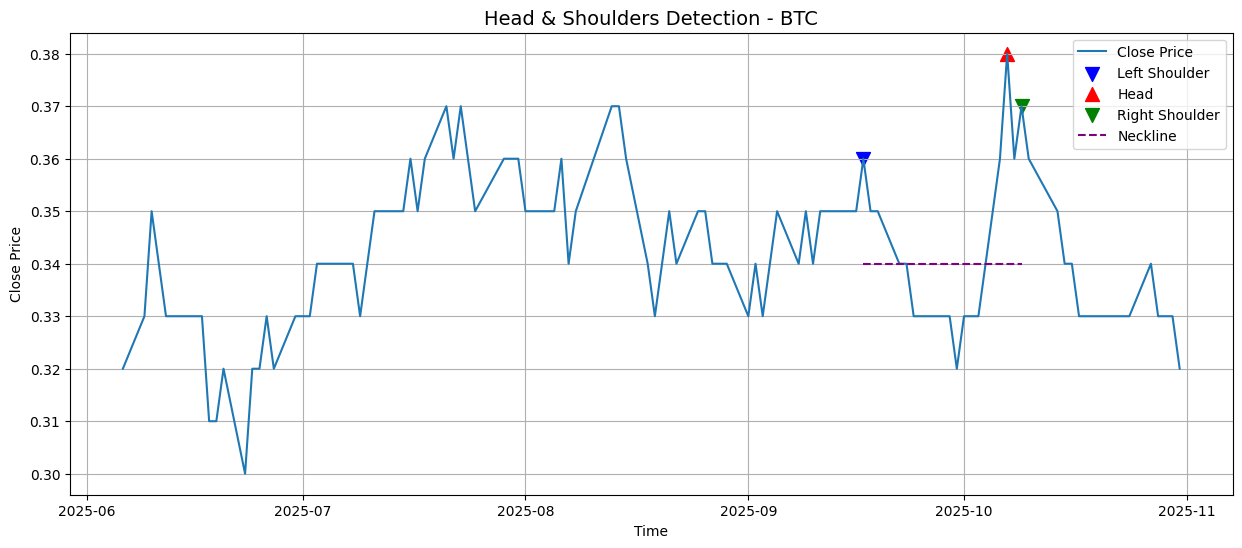

In [12]:
if __name__ == "__main__":
    symbol = "BTC"
    df = get_candlestick_data(symbol, limit=100)
    if df.empty:
        print("ไม่มีข้อมูลจาก Cassandra")
    else:
        patterns = detect_head_and_shoulders(df)
        if patterns:
            print(f"พบ {len(patterns)} pattern Head & Shoulders")
        else:
            print("ไม่พบ pattern Head & Shoulders")
        plot_head_and_shoulders(df, patterns, symbol)
